In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

In [2]:
from google.colab import files
uploaded = files.upload()

Saving FOOD-DATA-GROUP.csv to FOOD-DATA-GROUP.csv


In [3]:
df = pd.read_csv('FOOD-DATA-GROUP.csv')
df = df.drop("food", axis=1)
features = df.drop("Caloric Value", axis=1).columns.tolist()
target = "Caloric Value"

Selected features

In [4]:
df['Protein+Carbohydrates+Fat'] = df['Protein']+df['Carbohydrates']+df['Fat']
selected_features = ['Nutrition Density', 'Monounsaturated Fats', 'Phosphorus', 'Calcium', 'Sodium', 'Vitamin B11', 'Dietary Fiber', 'Copper', 'Selenium', 'Protein+Carbohydrates+Fat']
X = df[selected_features]
y = df[target]

Removing outliers

In [5]:
from scipy.stats import zscore
z_scores = np.abs(zscore(X))
threshold = 3
X_no_outliers = X[(z_scores < threshold).all(axis=1)]
df_no_outliers = df.loc[X_no_outliers.index]
print(f"Original shape: {df.shape}, Shape after removing outliers: {df_no_outliers.shape}")
X = df_no_outliers[selected_features]
y = df_no_outliers[target]

Original shape: (2395, 35), Shape after removing outliers: (2199, 35)


Splitting data into training and testing sets

In [9]:
test_samples = []
test_sizes = np.arange(0.01, 1.00, 0.01)

for test_size in test_sizes:
    try:
        # Split the dataset
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

        # Skip iterations with very small test sets
        if len(X_test) < 10 or len(X_train) < 10:
            print(f"Skipping test_size={test_size} due to small split sizes.")
            continue

        # Decision Tree
        dec_tree_model = DecisionTreeRegressor()
        dec_tree_model.fit(X_train, y_train)
        dec_tree_pred = dec_tree_model.predict(X_test)
        mse_dt = mean_squared_error(y_test, dec_tree_pred)
        r2_dt = r2_score(y_test, dec_tree_pred)

        # Append to test_samples only when all models succeed
        test_samples.append(X_test.shape[0])

    except Exception as e:
        print(f"Error at test_size={test_size}: {e}")
        continue

# Verify lengths
print(f"Length of test_samples: {len(test_samples)}")
print(f"Decision Tree - MSE: {mse_dt:.4f}, R^2: {r2_dt:.4f}")

Length of test_samples: 99
Decision Tree - MSE: 14065.9394, R^2: 0.6704


Performing experiments with different parameters to analyze their effect on performance.

In [10]:
# Experiment with different max_depth values
for max_depth in [3, 5, 10, None]:
    dt_model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"max_depth={max_depth}, MSE={mse:.4f}, R^2={r2:.4f}")

max_depth=3, MSE=11336.0020, R^2=0.7343
max_depth=5, MSE=12163.0095, R^2=0.7150
max_depth=10, MSE=12703.5955, R^2=0.7023
max_depth=None, MSE=12703.5955, R^2=0.7023


Compare Decision Tree with Other Models

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Support Vector Regressor": SVR()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: MSE={mse:.4f}, R^2={r2:.4f}")

Decision Tree: MSE=12703.5955, R^2=0.7023
Linear Regression: MSE=1682959.0608, R^2=-38.4399
Random Forest: MSE=12201.8674, R^2=0.7141
Support Vector Regressor: MSE=49222.0725, R^2=-0.1535


Investigate Overfitting and Generalization

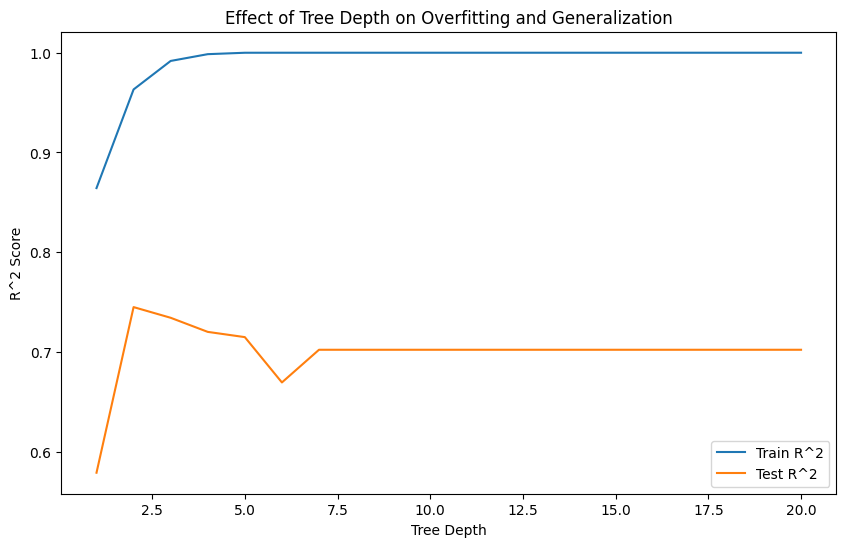

In [12]:
train_scores = []
test_scores = []

for max_depth in range(1, 21):
    dt_model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    dt_model.fit(X_train, y_train)
    train_scores.append(r2_score(y_train, dt_model.predict(X_train)))
    test_scores.append(r2_score(y_test, dt_model.predict(X_test)))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), train_scores, label="Train R^2")
plt.plot(range(1, 21), test_scores, label="Test R^2")
plt.xlabel("Tree Depth")
plt.ylabel("R^2 Score")
plt.title("Effect of Tree Depth on Overfitting and Generalization")
plt.legend()
plt.show()

Feature Importance

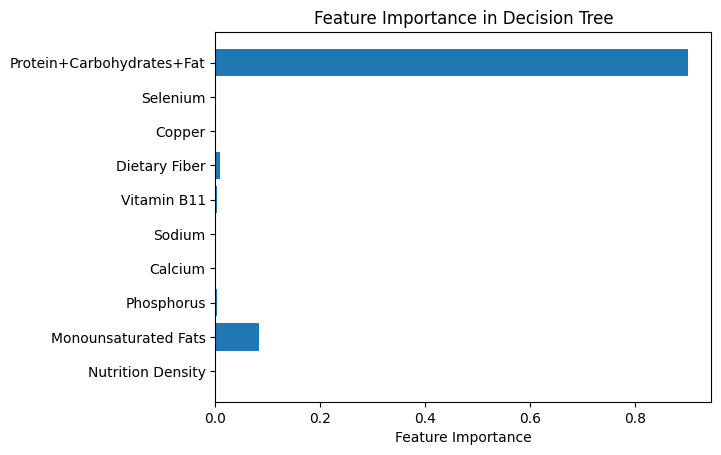

In [13]:
importances = dt_model.feature_importances_
plt.barh(selected_features, importances)
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Decision Tree")
plt.show()

Vary Train-Test Split Size

In [14]:
for split in [0.1, 0.3, 0.5, 0.7]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split, random_state=42)
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(X_train, y_train)
    y_pred = dt_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Train-Test Split={1-split:.0%}-{split:.0%}, MSE={mse:.4f}, R^2={r2:.4f}")

Train-Test Split=90%-10%, MSE=1570.7000, R^2=0.9651
Train-Test Split=70%-30%, MSE=3550.2761, R^2=0.9227
Train-Test Split=50%-50%, MSE=3540.2073, R^2=0.9210
Train-Test Split=30%-70%, MSE=4653.3675, R^2=0.8871


Cross-Validation to Evaluate Generalization Performance

Decision Tree CV Mean Squared Error: 5481.3653
Random Forest CV Mean Squared Error: 4139.5783
Linear Regression CV Mean Squared Error: 2175.8513


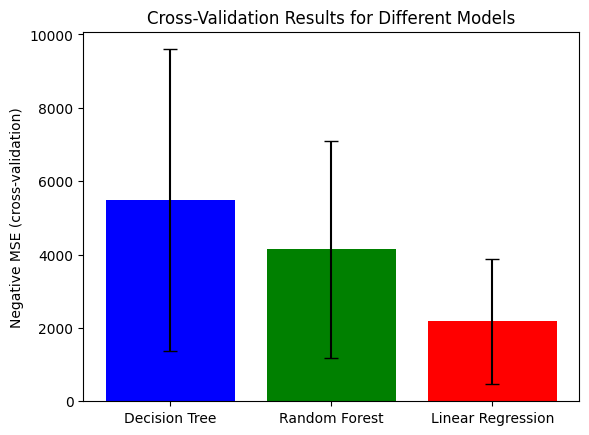

In [21]:
from sklearn.model_selection import cross_val_score

# Defining the models
dt_model = DecisionTreeRegressor(max_depth=5)  # Example: Control depth of the tree
rf_model = RandomForestRegressor(n_estimators=100, max_depth=5)  # Example: Random Forest with controlled depth
lr_model = LinearRegression()

# Performing cross-validation
dt_cv_scores = cross_val_score(dt_model, X, y, cv=5, scoring='neg_mean_squared_error')  # Using MSE as scoring
rf_cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
lr_cv_scores = cross_val_score(lr_model, X, y, cv=5, scoring='neg_mean_squared_error')

# Printing the cross-validation results (neg_mean_squared_error is returned as negative)
print(f"Decision Tree CV Mean Squared Error: {-dt_cv_scores.mean():.4f}")
print(f"Random Forest CV Mean Squared Error: {-rf_cv_scores.mean():.4f}")
print(f"Linear Regression CV Mean Squared Error: {-lr_cv_scores.mean():.4f}")

# Plotting cross-validation results for models
models = ['Decision Tree', 'Random Forest', 'Linear Regression']
cv_scores = [-dt_cv_scores.mean(), -rf_cv_scores.mean(), -lr_cv_scores.mean()]
cv_std = [dt_cv_scores.std(), rf_cv_scores.std(), lr_cv_scores.std()]

plt.bar(models, cv_scores, yerr=cv_std, capsize=5, color=['blue', 'green', 'red'])
plt.ylabel('Negative MSE (cross-validation)')
plt.title('Cross-Validation Results for Different Models')
plt.show()

Regularization to Control Complexity

In [19]:
# Decision Tree with Regularization
dt_model_reg = DecisionTreeRegressor(max_depth=5, min_samples_split=10, min_samples_leaf=5)
dt_model_reg.fit(X_train, y_train)

# Random Forest with Regularization
rf_model_reg = RandomForestRegressor(n_estimators=100, max_depth=5, min_samples_split=10, min_samples_leaf=5)
rf_model_reg.fit(X_train, y_train)

# Evaluating using Mean Squared Error (MSE)
dt_train_pred = dt_model_reg.predict(X_train)
rf_train_pred = rf_model_reg.predict(X_train)

dt_test_pred = dt_model_reg.predict(X_test)
rf_test_pred = rf_model_reg.predict(X_test)

# Calculating MSE on training and test set
from sklearn.metrics import mean_squared_error
print(f"Decision Tree Train MSE: {mean_squared_error(y_train, dt_train_pred):.4f}")
print(f"Random Forest Train MSE: {mean_squared_error(y_train, rf_train_pred):.4f}")
print(f"Decision Tree Test MSE: {mean_squared_error(y_test, dt_test_pred):.4f}")
print(f"Random Forest Test MSE: {mean_squared_error(y_test, rf_test_pred):.4f}")

Decision Tree Train MSE: 2209.5006
Random Forest Train MSE: 2113.4064
Decision Tree Test MSE: 3468.5483
Random Forest Test MSE: 2822.8619


Regularization in Linear Regression using Ridge (L2 Regularization) and Lasso (L1 Regularization):

In [20]:
from sklearn.linear_model import Ridge, Lasso

# Ridge Regression (L2 Regularization)
ridge_model = Ridge(alpha=1.0)  # alpha controls the strength of regularization
ridge_model.fit(X_train, y_train)

# Lasso Regression (L1 Regularization)
lasso_model = Lasso(alpha=0.1)  # alpha controls the strength of regularization
lasso_model.fit(X_train, y_train)

# Evaluating models
ridge_train_pred = ridge_model.predict(X_train)
lasso_train_pred = lasso_model.predict(X_train)

ridge_test_pred = ridge_model.predict(X_test)
lasso_test_pred = lasso_model.predict(X_test)

# Calculating MSE on training and test set
print(f"Ridge Train MSE: {mean_squared_error(y_train, ridge_train_pred):.4f}")
print(f"Lasso Train MSE: {mean_squared_error(y_train, lasso_train_pred):.4f}")
print(f"Ridge Test MSE: {mean_squared_error(y_test, ridge_test_pred):.4f}")
print(f"Lasso Test MSE: {mean_squared_error(y_test, lasso_test_pred):.4f}")

Ridge Train MSE: 1806.2951
Lasso Train MSE: 1806.5247
Ridge Test MSE: 2016.6924
Lasso Test MSE: 2014.8629


Training vs Testing MSE Comparison:

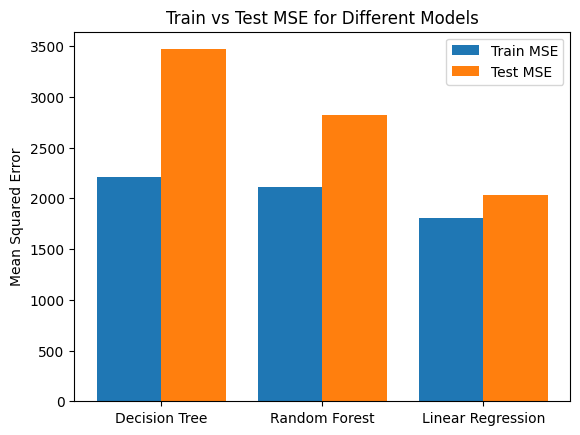

In [23]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model
lr_model.fit(X_train, y_train)

# Generate predictions for training and testing data
lr_train_pred = lr_model.predict(X_train)
lr_test_pred = lr_model.predict(X_test)

# Plotting Train vs Test MSE for different models
models = ['Decision Tree', 'Random Forest', 'Linear Regression']
train_mse = [mean_squared_error(y_train, dt_train_pred),
             mean_squared_error(y_train, rf_train_pred),
             mean_squared_error(y_train, lr_train_pred)]
test_mse = [mean_squared_error(y_test, dt_test_pred),
            mean_squared_error(y_test, rf_test_pred),
            mean_squared_error(y_test, lr_test_pred)]

x = np.arange(len(models))

plt.bar(x - 0.2, train_mse, 0.4, label='Train MSE')
plt.bar(x + 0.2, test_mse, 0.4, label='Test MSE')

plt.xticks(x, models)
plt.ylabel('Mean Squared Error')
plt.title('Train vs Test MSE for Different Models')
plt.legend()
plt.show()

Summarize Model Performance

In [24]:
# Define models to be evaluated
models = {
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Create a dictionary to store performance metrics
model_performance = {
    "Model": [],
    "MSE": [],
    "R^2": []
}

# Loop through each model, train, predict, and calculate performance metrics
for model_name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Make predictions

    # Calculate MSE and R^2 score
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Append the results to the dictionary
    model_performance["Model"].append(model_name)
    model_performance["MSE"].append(mse)
    model_performance["R^2"].append(r2)

# Convert the dictionary to a DataFrame for better visualization
performance_df = pd.DataFrame(model_performance)

# Display the summary of performance metrics
print(performance_df)


               Model          MSE       R^2
0      Decision Tree  4653.367532  0.887064
1  Linear Regression  2036.516642  0.950574
2      Random Forest  2295.870559  0.944280
